# Career Booster Python & Data Science

## Session 5 : Introduction au Deep Learning #2

*** 


Ce notebook est dédié à une implémentation d'un réseau de neurones profond basé sur des couches de convolution. Il s'agit de la correction de l'exercice énoncé à la fin de la session 4.

## Import des bibliothèques

In [1]:
# --- Manipulation de données
import numpy as np
import pandas as pd

# --- Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sn

# --- Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# A. Les données

Les données sont issues du dataset *MNIST*, provenant du [NIST][1] (**N**ational **I**nstitute of **S**tandards and **T**echnology).
Ce dataset consiste en 70 000 images de chiffres écrits à la main, images en noir & blanc et de taille 28x28 pixels (donc plutôt basse résolution). Ce jeu de données a été intensément utilisé par la communauté de Data Science pour mettre au point des modèles les plus performants possible, jusqu'à atteindre un taux d'erreur de 0.17% !

L'objectif va être de créer un modèle apprenant à classer ces images automatiquement. Une fois le modèle appris, nous pourrons classer des images nouvelles, c'est-à-dire des images que le modèle n'aura jamais vu !

[1]: https://en.wikipedia.org/wiki/MNIST_database

### 1. Import des données

Les données sont directement accessibles via Tensorflow / Keras. La première fois que vous lancez ce notebook, vous aurez à télécharger ces données (et ce téléchargement est fait automatiquement, vous n'avez rien à faire). Ensuite, ce ne sera plus la peine.

In [42]:
(images_train, labels_train), (images_test, labels_test) = keras.datasets.mnist.load_data()

### 2. Etude préliminaire des données

Keras nous permet directement d'accéder à une séparation de ce jeu de données en *deux sous jeux de données* : 
- un qui sera utilisé pour l'apprentissage : 60 000 images de 28 par 28 pixels
- un qui sera utilisé our le test : 10 000 images de 28 par 28 pixels également

Le premier sera donc utilisé pour **entraîner** le modèle tandis que le second sera utilisé pour **confronter** le modèle à des données qu'il n'a jamais vu. Nous pourrons donc réellement avoir une idée de la performance du modèle.

In [3]:
images_train.shape

(60000, 28, 28)

In [4]:
labels_train.shape

(60000,)

Les données *target* (le *y_train* ici) correspondent aux classes qu'il va falloir apprendre puis prédire.

In [44]:
labels_train

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [6]:
num_classes = 10
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
input_shape = (28, 28, 1)

In [7]:
images_train = images_train.astype("float32") / 255
images_test = images_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
images_train = np.expand_dims(images_train, -1)
images_test = np.expand_dims(images_test, -1)
print("images_train shape:", images_train.shape)

images_train shape: (60000, 28, 28, 1)


In [46]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test = keras.utils.to_categorical(labels_test, num_classes)

### 3. Visualisation

Il est indispensable de toujours essayer (lorsque c'est possible) de visualiser les données que nous allons avoir à traiter.

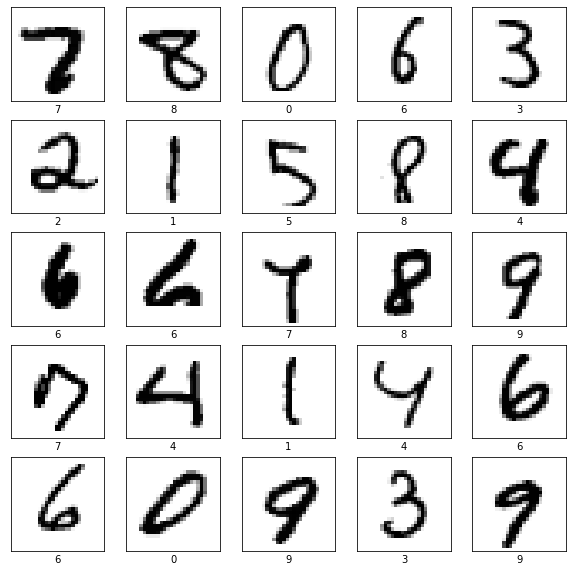

In [45]:
nb_images = images_train.shape[0]

random_indices = np.random.randint(0, nb_images, 25)

plt.figure(figsize=(10,10))

for iCpt, iIdx in enumerate(random_indices):
    plt.subplot(5, 5, iCpt+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[iIdx], cmap=plt.cm.binary)
    plt.xlabel(labels_train[iIdx])

plt.show()

## B. L'apprentissage

Nous allons ici utiliser un modèle **séquentiel** simple, c'est-à-dire un modèle composé :
- d'une couche d'entrée : c'est par là que les données vont entrer dans le modèle. Il y aura **28x28 neurones** d'entrée puisque nos images ont une dimension de 28 par 28 pixels
- d'une seule couche cachée contenant 128 neurones
- d'une couche de sortie : c'est par là que les prédictions du modèle vont être récupérées. Il y aura **10 neurones** ici puisqu'il y a 10 classes de vêtements à prédire.

### 1. Création du modèle

Nous créons le modèle via l'API de Keras, désormais complètement intégrée à Tensorflow (développé par Google).
Pour ce faire, nous additionnons les couches les unes aux autres, chacune avec des propriétés particulières.

In [ ]:
model = tf.keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

Jetons un coup d'oeil sur ce modèle :

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Chaque couches (*layer*) possède un vecteur de poids ainsi qu'un vecteur de biais. C'est cette architecture qui permet l'apprentissage et ce sont ces valeurs (principalement) que le modèle va essayer de modifier lors de l'apprentissage afin que les prédictions que le modèle effectue soient de plus en plus proches de la référence qui lui ai donné.

A noter que par défaut, les biais sont tous initialisés à 0 en début d'apprentissage.

In [13]:
model.layers[0].weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.00772604, -0.09506416,  0.01936913,  0.03033985,
            0.13520922,  0.01138483, -0.05784102,  0.06864579,
           -0.0152573 ,  0.08080409, -0.04281059, -0.09334553,
            0.11552007, -0.00221728, -0.00326867, -0.07246798,
           -0.07405587,  0.10554278, -0.07139223,  0.13237758,
            0.01419345,  0.08020473, -0.13556439, -0.04317085,
           -0.02921089, -0.01033686, -0.05238275,  0.10820536,
            0.00053711,  0.13115649, -0.02217025, -0.13771765]],
 
         [[ 0.10600649, -0.10106023,  0.10558619,  0.11934809,
            0.10112102,  0.13627918,  0.13681234,  0.08471575,
           -0.01088028,  0.1341692 ,  0.0423892 ,  0.1227987 ,
            0.05440117,  0.13867216,  0.08378144, -0.04694349,
            0.03783952, -0.11147103, -0.03870531, -0.02510096,
            0.1062052 ,  0.02589419, -0.07596177, -0.09150467,
           -0.14195113,  0.06864041, -0.

Le modèle étant maintenant créé, il est nécessaire de le compiler.

In [14]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

### 2. Entraînement du modèle

Nous pouvons maintenant entraîner le modèle avec comme arguments :
- *X_train* : les données d'entraînement, c'est-à-dire 48 000 images
- *y_train* : les 48 000 labels correspondant
- *epochs* : un nombre d'itération, c'est-à-dire de fois où le modèle va effectuer une passe sur toutes les données d'apprentissage
- *validation_data* : les données de validation, elles aussi composées d'images et de labels correspondants
- *callbacks* : une liste des fonctions à appeler à chaque fin d'époques / d'itérations.

In [15]:
batch_size = 128
nb_epochs = 15
validation_split = 0.1

history = model.fit(images_train,
                    labels_train,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    validation_split=validation_split)

Epoch 1/15
422/422 [==============================] - 14s 32ms/step - loss: 0.3552 - accuracy: 0.8926 - val_loss: 0.0866 - val_accuracy: 0.9767
Epoch 2/15
422/422 [==============================] - 14s 32ms/step - loss: 0.1154 - accuracy: 0.9644 - val_loss: 0.0580 - val_accuracy: 0.9850
Epoch 3/15
422/422 [==============================] - 14s 34ms/step - loss: 0.0879 - accuracy: 0.9724 - val_loss: 0.0476 - val_accuracy: 0.9870
Epoch 4/15
422/422 [==============================] - 14s 32ms/step - loss: 0.0732 - accuracy: 0.9775 - val_loss: 0.0462 - val_accuracy: 0.9860
Epoch 5/15
422/422 [==============================] - 15s 36ms/step - loss: 0.0646 - accuracy: 0.9800 - val_loss: 0.0380 - val_accuracy: 0.9893
Epoch 6/15
422/422 [==============================] - 16s 39ms/step - loss: 0.0559 - accuracy: 0.9828 - val_loss: 0.0386 - val_accuracy: 0.9897
Epoch 7/15
422/422 [==============================] - 15s 37ms/step - loss: 0.0530 - accuracy: 0.9831 - val_loss: 0.0366 - val_accuracy:

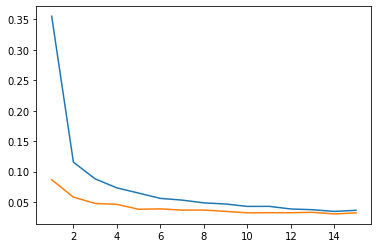

In [16]:
plt.plot(range(1, nb_epochs+1), history.history["loss"])
plt.plot(range(1, nb_epochs+1), history.history["val_loss"])
plt.show()

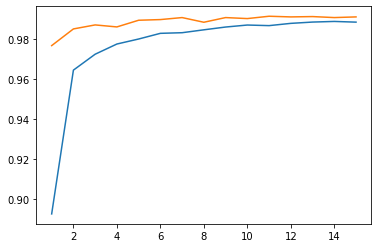

In [17]:
plt.plot(range(1, nb_epochs+1), history.history["accuracy"])
plt.plot(range(1, nb_epochs+1), history.history["val_accuracy"])
plt.show()

### 3. Visualisation des résultats

L'apprentissage est maintenant terminé. Nous pouvons visualiser l'évolution des métriques que nous avons définies plus haut :

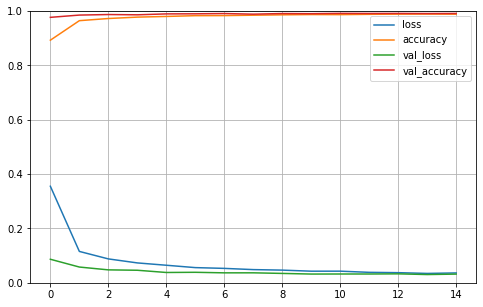

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### 4. Evaluation du modèle

Le modèle est entraîné et nous considérons que les valeurs de *loss* sont suffisament hautes pour arrêter l'apprentissage. Nous pouvons donc désormais *utiliser* ce modèle pour faire de la prédiction.

Nous allons alors commencer par effectuer des prédictions sur le jeu de données test, jeu de données, pour rappel, que le modèle n'a **jamais** vu mais pour lequel nous connaissons le label à prédire — c'est tout l'intérêt du jeu de test !

In [19]:
test_loss, test_acc = model.evaluate(images_test,  labels_test, verbose=2)

313/313 - 0s - loss: 0.0251 - accuracy: 0.9917


Nous voyons ici que l'*accuracy* est d'environ 85%, une valeur inférieure à ce que nous avons observé sur le jeu de train d'une part et sur le jeu de validation d'autre part.
C'est totalement normal ! Le jeu de données test correspond à des données totalement nouvelles pour le modèle, il est donc logique qu'il s'en sorte un peu moins bien que sur les données qu'il a eu l'occasion de traiter de nombreuses fois (cf. nombre d'époques).

### 5. Prédictions

On effectue une prédiction sur trois images du jeu de données de test (jamais vue auparavant par le modèle)

In [20]:
X_new = images_test[:3]
y_proba = model.predict(X_new)
y_proba

array([[2.0949539e-10, 2.2553043e-10, 2.2591967e-06, 1.2398220e-06,
        2.3501391e-13, 1.0337556e-10, 2.7306893e-17, 9.9999654e-01,
        2.6308267e-09, 2.6954622e-08],
       [3.9401912e-06, 2.5093566e-05, 9.9995160e-01, 2.7951090e-08,
        2.0644926e-09, 7.7955377e-12, 1.8899431e-05, 1.6552625e-10,
        3.1399878e-07, 1.3050663e-11],
       [5.9134209e-08, 9.9977797e-01, 1.3078105e-06, 3.9580911e-08,
        1.3636728e-04, 4.3647370e-07, 2.4748633e-06, 7.4686977e-05,
        6.1962605e-06, 4.2181486e-07]], dtype=float32)

Si l'on souhaite avoir des classes prédites plutôt que des probas d'appartenance

In [21]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(images_test)

In [22]:
predictions[0]

array([0.08533679, 0.08533679, 0.08533698, 0.08533689, 0.08533679,
       0.08533679, 0.08533679, 0.23196864, 0.08533679, 0.08533679],
      dtype=float32)

In [23]:
np.argmax(predictions[0])

7

In [24]:
labels_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [25]:
def plot_image_and_probas(
    image,
    predictions,
    true_label,
    labels
):
    """Description
    
    Parameters
    ----------
    image : 2D matrix
    
    predictions : 2D matrix

    true_label : 
    
    labels : list of str
        All possible labels
    
    Returns
    -------
    """
    fig = plt.figure(figsize=(8, 4),
                     constrained_layout=True)
    
    spec = gridspec.GridSpec(ncols=2,
                             nrows=1,
                             figure=fig)
    
    fig.add_subplot(spec[0, 0])
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image, cmap = plt.cm.binary)

    predicted_label = np.argmax(predictions)

    color = 'blue'
    if predicted_label != true_label:
        color = 'red'

    disp_pred_label = labels[predicted_label]
    disp_pred = round(100*np.max(predictions))/100
    disp_true_label = labels[true_label]
    plt.xlabel(
        f"Pred.: {disp_pred_label}, proba: {disp_pred}, true label: {disp_true_label}",
        color=color)

    # --- Second subplot
    fig.add_subplot(spec[0, 1])
    
    plt.grid(False)
    plt.xticks(range(10))
    
    plt_bar = plt.bar(range(len(labels)),
                       predictions,
                       color="#777777")
    
    plt_bar[predicted_label].set_color('red')
    plt_bar[true_label].set_color('blue')
    
    locs, _ = plt.xticks()
    plt.xticks(ticks=locs, labels=labels, rotation=45)
    
    plt.show()

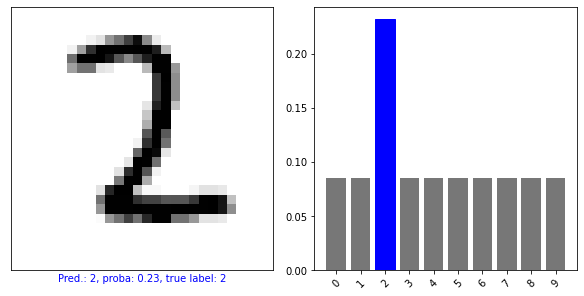

In [63]:
idx = np.random.randint(0, len(images_test), 1)[0]

plot_image_and_probas(images_test[idx],
                      predictions[idx],
                      np.argmax(labels_test[idx]),
                      class_names)

### 6. Analyse des limites du modèle

Le jeu de données test va nous servir à étudier où le modèle est moins performant :
- est-ce pour toutes les classes ?
- ou sont-ce seulement certaines classes qui sont plus dures à modéliser ?

Pour cela, nous allons utiliser la matrice de confusion introduite à la session 4.

In [28]:
confusion_matrix = tf.math.confusion_matrix(
    np.argmax(labels_test, axis=1),
    np.argmax(predictions, axis=1),
    num_classes=10
)
confusion_matrix = np.array(confusion_matrix)

In [29]:
confusion_matrix

array([[ 974,    0,    0,    0,    1,    0,    3,    1,    1,    0],
       [   0, 1130,    1,    1,    0,    0,    1,    2,    0,    0],
       [   1,    1, 1020,    2,    0,    0,    0,    7,    1,    0],
       [   0,    0,    1, 1007,    0,    1,    0,    0,    1,    0],
       [   0,    0,    0,    0,  976,    0,    0,    0,    0,    6],
       [   0,    0,    1,    5,    0,  883,    1,    1,    0,    1],
       [   1,    2,    0,    0,    2,    3,  949,    0,    1,    0],
       [   0,    2,    4,    1,    0,    1,    0, 1019,    1,    0],
       [   2,    0,    1,    1,    1,    1,    0,    2,  962,    4],
       [   0,    0,    0,    1,    2,    3,    0,    5,    1,  997]],
      dtype=int32)

Même s'il n'est pas trop compliqué de lire cette matrice, il est beaucoup plus parlant de la représenter sous forme d'image :

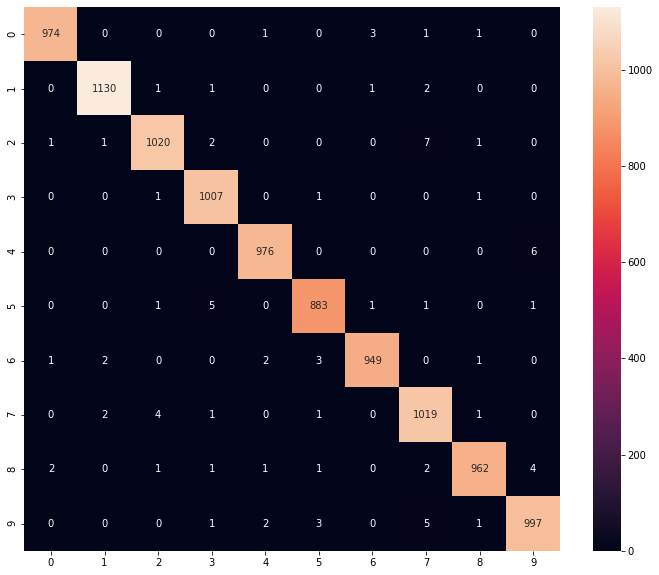

In [30]:
df_cm = pd.DataFrame(np.array(confusion_matrix),
                     index = class_names,
                     columns = class_names)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, fmt="G");

Observations : A VOUS !